In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd

# Библиотека LabPlot

In [2]:
# LabPlt created by Nikita Balagansky. MIPT.
# https://github.com/PUSSYMIPT/labplot
# This Python file uses the following encoding: utf-8

def leastsqr(x, y):
    import numpy as np
    b = (np.mean(x * y) - np.mean(x) * np.mean(y)) /\
        (np.mean(x * x) - np.mean(x) ** 2)
    a = np.mean(y) - b * np.mean(x)
    sig_b = np.sqrt(((np.mean(y ** 2) - np.mean(y) ** 2)/((np.mean(x ** 2) - np.mean(x) ** 2)) - b ** 2)/len(x))
    sig_a = sig_b * (np.mean(x * x) - np.mean(x) ** 2) ** 0.5
    return b, a, sig_b, sig_a


def make_plot(x, y, lab_x='', lab_y='', title='', err_y=None, grid=True,
                y_scale='linear', interpolate_type='RBF', degree=None,
                smooth=True, linear=True, borders=True):
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, interpolate, BarycentricInterpolator
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import TheilSenRegressor, Ridge
    left_boarder = min(x) if borders else min(x) - 0.1 * (max(x) - min(x))
    right_boarder = max(x) if borders else max(x) + 0.1 * (max(x) - min(x))
    x1 = np.linspace(left_boarder, right_boarder, 400)
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.xlabel(lab_x)
    plt.ylabel(lab_y)
    plt.grid(grid)
    ax.set_yscale(y_scale)
    ax.errorbar(x, y, yerr=err_y, color='r', label=u'Данные', fmt='.')
    if smooth:
        X_plot = x1[:, np.newaxis]
        flag_model = False
        if interpolate_type == 'RBF':
            smth = Rbf(x, y)
        elif interpolate_type == 'IUS':
            smth = InterpolatedUnivariateSpline(x, y)
        elif interpolate_type == 'cubic':
            smth = interpolate(x, y, kind='cubic', bc_type='natural')
        elif interpolate_type == 'polynomial_r':
            X = x[:, np.newaxis]
            degree = int(degree)
            import warnings
            warnings.filterwarnings(action="ignore", module="scipy",
                                    message="^internal gelsd")
            smth = make_pipeline(PolynomialFeatures(degree),
                                 Ridge(alpha=1*10**-16))
            smth.fit(X, y)
            flag_model = True
        elif interpolate_type == 'polynomial_t':
            X = x[:, np.newaxis]
            degree = int(degree)
            import warnings
            warnings.filterwarnings(action="ignore", module="scipy",
                                    message="^internal gelsd")
            smth = make_pipeline(PolynomialFeatures(degree),
                                 TheilSenRegressor())
            smth.fit(X, y)
            flag_model = True
        else:
            print("Invalid interpolate type: You can choose\
                   RBF, IUS, cubic or polynomial")
            return
        if flag_model:
            y1 = smth.predict(X_plot)
        else:
            y1 = smth(x1)
        plt.plot(x1, y1, color='g', label=u'Сглаживание')
    b1, a1, sig_b1, sig_a1 = leastsqr(x, y)
    label_ = u'\nb={}±{}  a={}±{}'.format(np.round(b1, 3), np.round(sig_b1, 3),
                                          np.round(a1, 3), np.round(sig_a1, 3))
    ax.set_title(title)
    if linear:
        plt.plot(x1, b1 * x1 + a1, label=u'Линейная апроксимация' + label_)
    plt.legend()
    return fig, ax


def make_plots(x_array, y_array, labels, err_y=0, title='', x_label='',
               style='different', y_label='', grid=False, method='cubic',
               degree=1):
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy.interpolate import CubicSpline
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression, Ridge
    from matplotlib import cm
    fig, ax = plt.subplots(figsize=(12, 8))
    if style == 'blue':
        colors_points = cm.autumn(np.linspace(0, 1, len(x_array)))
        colors_plots = ['b' for i in range(len(x_array))]
    if style == 'different':
        colors_points = cm.tab10(np.linspace(0, 0.49, len(x_array)))
        colors_plots = cm.tab10(np.linspace(0.5, 1, len(x_array)))
    
    if err_y:
        for x, y, c_point, l, c_plot, e_y in zip(x_array, y_array, colors_points,
                                        labels, colors_plots, err_y):
            x_plot = np.linspace(min(x), max(x), 200)
            ax.errorbar(x, y, fmt='o', yerr=e_y, label=l, color=c_point)
            plt.legend()
            if method == 'cubic':
                smth = CubicSpline(x, y)
                y_plot = smth(x_plot)
            elif method == 'polynomial':
                x_pol = x[:, np.newaxis]
                degree = int(degree)
                import warnings
                warnings.filterwarnings(action="ignore", module="scipy",
                                        message="^internal gelsd")
                smth = make_pipeline(PolynomialFeatures(degree),
                                     Ridge(alpha=1*10**-16))
                smth.fit(x_pol, y)
                y_plot = smth.predict(x_plot[:, np.newaxis])
            plt.plot(x_plot, y_plot, color=c_plot)
    else:
        for x, y, c_point, l, c_plot in zip(x_array, y_array, colors_points,
                                        labels, colors_plots):
            x_plot = np.linspace(min(x), max(x), 200)
            ax.errorbar(x, y, fmt='o', yerr=0, label=l, color=c_point)
            plt.legend()
            if method == 'cubic':
                smth = CubicSpline(x, y)
                y_plot = smth(x_plot)
            elif method == 'polynomial':
                x_pol = x[:, np.newaxis]
                degree = int(degree)
                import warnings
                warnings.filterwarnings(action="ignore", module="scipy",
                                        message="^internal gelsd")
                smth = make_pipeline(PolynomialFeatures(degree),
                                     Ridge(alpha=1*10**-16))
                smth.fit(x_pol, y)
                y_plot = smth.predict(x_plot[:, np.newaxis])
            plt.plot(x_plot, y_plot, color=c_plot)
    ax.set_title(title)
    plt.grid(grid)
    plt.xlabel(x_label)
    plt.ylabel(y_label)


def interpolate_values(x, y, method='cubic'):
    from scipy.interpolate import CubicSpline
    import numpy as np
    x_interpolated = np.linspace(min(x), max(x), 500)
    if method == 'cubic':
        smth = CubicSpline(x, y)
        y_interpolated = smth(x_interpolated)
    return x_interpolated, y_interpolated


def find_nearest(array, value):
    import numpy as np
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


Запись таблиц в csv.

In [3]:
frame1 = pd.DataFrame(x9)
frame1 = frame1.copy().T
frame1.columns = [first, 
                  second, 
                  third]
frame1

NameError: name 'x9' is not defined

In [ ]:
frame1.to_csv('zink_dataset.csv', sep=',', header=True, index=False)

# Измерения

$\textbf{Таблица 1.}$ Зависимость индукции магнитного поля от тока через магнит.

In [4]:
x1 = np.array([[0.15, 0.25, 0.4, 0.55, 0.7, 0.85, 1, 1.15, 1.28], 
               [174.3, 304.7, 488.4, 665, 812.2, 935.4, 1011.4, 1065.3, 1103.8]])

$\textbf{График 1.}$ Зависимость индукции магнитного поля от тока через магнит.

Погрешность магнитометра $\sigma_B = 0.1$

In [5]:
params = ['I', 'B']

In [6]:
fr = pd.read_csv('tubs/dataset.csv', header=0, sep=',')

In [94]:
'''make_plot(fr[params[0]],
          fr[params[1]], 
          lab_x='Ток через магнит, А', 
          lab_y='Магнитная индукция, мТл',
          linear=False,
          interpolate_type="polynomial_t",
          degree=2)'''

'make_plot(fr[params[0]],\n          fr[params[1]], \n          lab_x=\'Ток через магнит, А\', \n          lab_y=\'Магнитная индукция, мТл\',\n          linear=False,\n          interpolate_type="polynomial_t",\n          degree=2)'

$\textbf{Таблица 2.}$ Зависимость ЭДС Холла от индукции при различных значениях тока через медный образец.

$I_{обр} = 0.2А$

In [8]:
x2 = np.array([[0.2, 0.38, 0.50, 0.7, 0.85, 1.09, 1.26], 
               [308.5, 457.27, 561.73, 728.16, 851.73, 1053.64, 1195.96],
               [3, 9, 12, 15, 18, 21, 23]])

$I_{обр} = 0.32А$

In [9]:
x3 = np.array([[0.19, 0.36, 0.49, 0.68, 0.84, 1.08, 1.24], 
               [303.21, 450.11, 552.36, 716.60, 849.15, 1040.48, 1184.19],
               [6, 13, 18, 24, 29, 33, 36]])

$I_{обр} = 0.45А$

In [10]:
x4 = np.array([[0.18, 0.35, 0.48, 0.67, 0.84, 1.07, 1.22], 
               [287.84, 434.95, 544.99, 704.04, 840.57, 1029.32, 1177.43],
               [8, 17, 24, 32, 39, 45, 48]])

$I_{обр} = 0.58А$

In [11]:
x5 = np.array([[0.16, 0.34, 0.47, 0.65, 0.83, 1.06, 1.21], 
               [280.47, 423.79, 532.62, 686.49, 837.99, 1023.16, 1166.66],
               [11, 21, 30, 41, 50, 57, 61]])

$I_{обр} = 0.71А$

In [12]:
x6 = np.array([[0.16, 0.33, 0.46, 0.64, 0.83, 1.04, 1.2], 
               [278.09, 415.62, 528.24, 675.93, 831.40, 1006.99, 1154.89],
               [13, 25, 36, 49, 60, 69, 74]])

$I_{обр} = 0.84А$

In [13]:
x7 = np.array([[0.15, 0.32, 0.45, 0.62, 0.82, 1.03, 1.2], 
               [263.72, 401.46, 515.87, 662.37, 823.82, 996.83, 1146.13],
               [16, 29, 42, 58, 71, 81, 86]])

$I_{обр}  = 0.97А$

In [14]:
x8 = np.array([[0.14, 0.30, 0.44, 0.61, 0.81, 1.01, 1.19], 
               [258.35, 392.30, 510.50, 653.81, 819.24, 986.67, 1139.36], 
               [18, 33, 48, 66, 81, 93, 99]])

$\textbf{График 2.}$ Зависимость ЭДС Холла от индукции при различных значениях тока через медный образец.

Таблица с параметрами прямых, соответсвующих зависимости ЭДС Холла от магнитной индукции, и погрешностями.

In [15]:
lines_and_sigms = pd.DataFrame({'b1':[], 'a1':[], 'sig_b1':[], 'sig_a1':[]}) #датафрейм с прямыми

In [95]:
'''make_plot(x2[1],
          x2[2],
          linear=False,
          interpolate_type="polynomial_t",
          degree=3,
          err_y=0)'''

'make_plot(x2[1],\n          x2[2],\n          linear=False,\n          interpolate_type="polynomial_t",\n          degree=3,\n          err_y=0)'

In [17]:
b1, a1, sig_b1, sig_a1 = leastsqr(x2[1], x2[2])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.02150183817197492 -1.412109204927562 0.0015657578046523466 0.46475261047795235


In [18]:
new_line = {'b1': b1, 'a1': a1, 'sig_b1': sig_b1, 'sig_a1': sig_a1}
lines_and_sigms = lines_and_sigms.append(new_line, ignore_index=True)

In [96]:
'''make_plot(x3[1],
          x3[2],
          linear=False,
          interpolate_type="polynomial_t",
          degree=3,
          err_y=0)'''

'make_plot(x3[1],\n          x3[2],\n          linear=False,\n          interpolate_type="polynomial_t",\n          degree=3,\n          err_y=0)'

In [20]:
b1, a1, sig_b1, sig_a1 = leastsqr(x3[1], x3[2])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.03390253706292293 -1.9672455894802177 0.002131135304417715 0.6286354547138409


In [21]:
new_line = {'b1': b1, 'a1': a1, 'sig_b1': sig_b1, 'sig_a1': sig_a1}
lines_and_sigms = lines_and_sigms.append(new_line, ignore_index=True)

In [97]:
'''make_plot(x4[1],
          x4[2],
          linear=False,
          interpolate_type="polynomial_t",
          degree=3,
          err_y=0)'''

'make_plot(x4[1],\n          x4[2],\n          linear=False,\n          interpolate_type="polynomial_t",\n          degree=3,\n          err_y=0)'

In [23]:
b1, a1, sig_b1, sig_a1 = leastsqr(x4[1], x4[2])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.0456075483779347 -2.2729529093753165 0.002869228571429052 0.8527348274190503


In [24]:
new_line = {'b1': b1, 'a1': a1, 'sig_b1': sig_b1, 'sig_a1': sig_a1}
lines_and_sigms = lines_and_sigms.append(new_line, ignore_index=True)

In [98]:
'''make_plot(x5[1],
          x5[2],
          linear=False,
          interpolate_type="polynomial_t",
          degree=3,
          err_y=0)'''

'make_plot(x5[1],\n          x5[2],\n          linear=False,\n          interpolate_type="polynomial_t",\n          degree=3,\n          err_y=0)'

In [26]:
b1, a1, sig_b1, sig_a1 = leastsqr(x5[1], x5[2])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.05763733128782491 -2.0532574179504195 0.0036266805668677933 1.0805238584141617


In [27]:
new_line = {'b1': b1, 'a1': a1, 'sig_b1': sig_b1, 'sig_a1': sig_a1}
lines_and_sigms = lines_and_sigms.append(new_line, ignore_index=True)

In [99]:
'''make_plot(x6[1],
          x6[2],
          linear=False,
          interpolate_type="polynomial_t",
          degree=3,
          err_y=0)'''

'make_plot(x6[1],\n          x6[2],\n          linear=False,\n          interpolate_type="polynomial_t",\n          degree=3,\n          err_y=0)'

In [29]:
b1, a1, sig_b1, sig_a1 = leastsqr(x6[1], x6[2])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.07109634031965124 -3.1062251311236366 0.004216200281456567 1.2419488074259577


In [30]:
new_line = {'b1': b1, 'a1': a1, 'sig_b1': sig_b1, 'sig_a1': sig_a1}
lines_and_sigms = lines_and_sigms.append(new_line, ignore_index=True)

In [100]:
'''make_plot(x7[1],
          x7[2],
          linear=False,
          interpolate_type="polynomial_t",
          degree=3,
          err_y=0)'''

'make_plot(x7[1],\n          x7[2],\n          linear=False,\n          interpolate_type="polynomial_t",\n          degree=3,\n          err_y=0)'

In [32]:
b1, a1, sig_b1, sig_a1 = leastsqr(x7[1], x7[2])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.0820651983004936 -1.6785738378620465 0.005233941254391631 1.5527710369676195


In [33]:
new_line = {'b1': b1, 'a1': a1, 'sig_b1': sig_b1, 'sig_a1': sig_a1}
lines_and_sigms = lines_and_sigms.append(new_line, ignore_index=True)

In [101]:
'''make_plot(x8[1],
          x8[2],
          linear=False,
          interpolate_type="polynomial_t",
          degree=3,
          err_y=0)'''

'make_plot(x8[1],\n          x8[2],\n          linear=False,\n          interpolate_type="polynomial_t",\n          degree=3,\n          err_y=0)'

In [35]:
b1, a1, sig_b1, sig_a1 = leastsqr(x8[1], x8[2])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.09490652043264085 -1.9681236798671335 0.00577546798391493 1.7110848899097566


In [36]:
new_line = {'b1': b1, 'a1': a1, 'sig_b1': sig_b1, 'sig_a1': sig_a1}
lines_and_sigms = lines_and_sigms.append(new_line, ignore_index=True)

In [37]:
lines_and_sigms

,b1,a1,sig_b1,sig_a1
0,0.021502,-1.412109,0.001566,0.464753
1,0.033903,-1.967246,0.002131,0.628635
2,0.045608,-2.272953,0.002869,0.852735
3,0.057637,-2.053257,0.003627,1.080524
4,0.071096,-3.106225,0.004216,1.241949
5,0.082065,-1.678574,0.005234,1.552771
6,0.094907,-1.968124,0.005775,1.711085


In [38]:
lines_and_sigms.to_csv('lines_and_sigms.csv', sep=',', header=True, index=False)

### Зависимость $K = f(I)$

In [39]:
params = ['I', 'K']
a = 0.05#мм, толщина пластинки

In [40]:
x10 = np.array([[0.2, 0.32, 0.45, 0.58, 0.71, 0.84, 0.97],
                [0.094907, 0.082065, 0.071096, 0.057637, 0.045608, 0.033903, 0.021502]])

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1fbc0f28>)

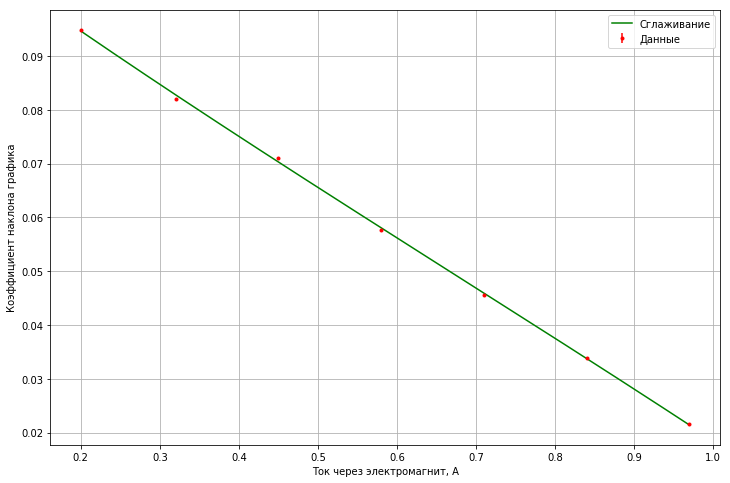

In [41]:
make_plot(x10[0],
          x10[1], 
          lab_x='Ток через электромагнит, А', 
          lab_y='Коэффициент наклона графика',
          linear=False,
          interpolate_type="polynomial_t",
          degree=3,
          err_y=0)

In [56]:
b1, a1, sig_b1, sig_a1 = leastsqr(x10[0], x10[1])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

-0.09473000859317418 0.11318130499631698 0.0007798097623144063 0.00020109108911656046


Найдем постоянную Холла $R_x$. $R_x = -\dfrac{\partial E_x}{\partial B}\cdot\dfrac{a}{I}$. Значение $a = 0.05$ мм. Остальное лежит в x10.

In [92]:
R = -x10[1]/x10[0]*0.05/1000/1000

In [93]:
R#постоянная Холла

array([-2.37267500e-08, -1.28226563e-08, -7.89955556e-09, -4.96870690e-09,
       -3.21183099e-09, -2.01803571e-09, -1.10835052e-09])

In [91]:
R.mean()

-7.658775538155551e-09

#### Концентрация носителей заряда в медном проводнике:

In [102]:
e = -1.6021766208*(10**(-19))

In [103]:
n = 1/R/e

In [104]:
n.mean()#среднее значение

1.9233695414565388e+27

In [105]:
n

array([2.63057904e+26, 4.86756332e+26, 7.90108897e+26, 1.25616368e+27,
       1.94328691e+27, 3.09286356e+27, 5.63134950e+27])

#### Концентрация носителей заряда в цинковом проводнике:

In [77]:
n = 1/(4.57*10**(-9))/e

In [78]:
n

-1.365756920324564e+27

$\textbf{Таблица 3.}$ Зависимость ЭДС Холла от индукции при различных значениях тока через цинковый образец.

In [44]:
x9 = np.array([[0.15, 0.30, 0.45, 0.59, 0.76, 0.93, 1.10], 
               [266.72, 392.30, 517.87, 635.07, 777.38, 919.70, 1062.02],
               [-12, -24, -39, -51, -63, -72, -78]])

$\textbf{График 3.}$ Зависимость ЭДС Холла от индукции при различных значениях тока через цинковый образец.

In [45]:
params = ['I', 'B', 'E_x']

In [46]:
fr = pd.read_csv('tubs/zink_dataset.csv', header=0, sep=',')

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a201966d8>)

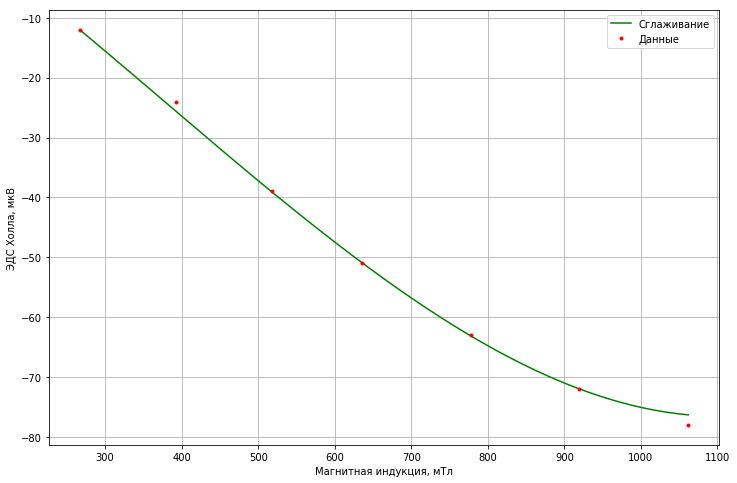

In [47]:
make_plot(fr[params[1]],
          fr[params[2]], 
          lab_x='Магнитная индукция, мТл', 
          lab_y='ЭДС Холла, мкВ',
          linear=False,
          interpolate_type="polynomial_t",
          degree=3)
          #err_y=0.05*x9[2])

In [48]:
b1, a1, sig_b1, sig_a1 = leastsqr(x8[1], x8[2])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.09490652043264085 -1.9681236798671335 0.00577546798391493 1.7110848899097566


$\textbf{График 4.}$ Серия измерений.

In [49]:
params = ['I', 'B', 'E_x']

In [50]:
fr1 = pd.read_csv('tubs/1_dataset.csv', header=0, sep=',')
fr2 = pd.read_csv('tubs/2_dataset.csv', header=0, sep=',')
fr3 = pd.read_csv('tubs/3_dataset.csv', header=0, sep=',')
fr4 = pd.read_csv('tubs/4_dataset.csv', header=0, sep=',')
fr5 = pd.read_csv('tubs/5_dataset.csv', header=0, sep=',')
fr6 = pd.read_csv('tubs/6_dataset.csv', header=0, sep=',')
fr7 = pd.read_csv('tubs/7_dataset.csv', header=0, sep=',')

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.228945e-35
  overwrite_a=True).T
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.490163e-35
  overwrite_a=True).T
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.644875e-35
  overwrite_a=True).T
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.841272e-35
  overwrite_a=True).T
/anaconda3/lib/python3.6

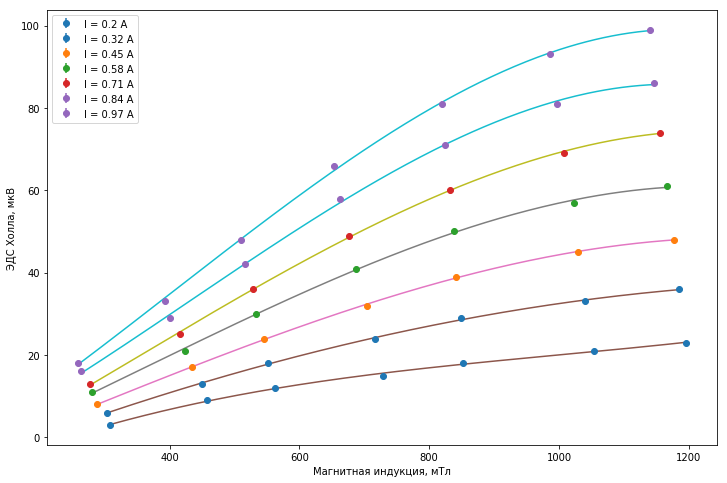

In [51]:
X = [fr1[params[1]], fr2[params[1]],
     fr3[params[1]], fr4[params[1]],
     fr5[params[1]], fr6[params[1]], fr7[params[1]]]
Y = [fr1[params[2]], fr2[params[2]],
     fr3[params[2]], fr4[params[2]],
     fr5[params[2]], fr6[params[2]], fr7[params[2]]]
#Err_y = [0.05*x2[2], 0.05*x7[2]]
labels = ['I = 0.2 A', 'I = 0.32 A', 
          'I = 0.45 A', 'I = 0.58 A', 
          'I = 0.71 A', 'I = 0.84 A', 'I = 0.97 A']
import warnings
warnings.filterwarnings(action="ignore", module="sklearn",
                                    message="^internal gelsd")
make_plots(X, Y, x_label='Магнитная индукция, мТл', y_label='ЭДС Холла, мкВ', labels=labels, method='polynomial', degree=3)

# Остальное.

In [52]:
x = np.array([0, 0.2, 0.38, 0.49, 0.7, 0.85])
y = np.array([-4, -3, -1, 0, 1, 2])

In [53]:
# calc the trendline (it is simply a linear fitting)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

polyX = np.linspace(x.min(), x.max(), 10)

y=7.309981x+(-4.025358)


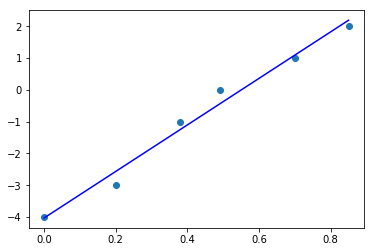

In [54]:
# the line equation:
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.plot(x, y, 'o')
plt.plot(x, p(x), "b")
plt.show()